In [1]:
import networkx as nx
import numpy as np
from sympy.matrices import Matrix,GramSchmidt
import torch
from torch_geometric.utils import from_networkx
from sklearn.utils import shuffle
from torch_geometric.transforms import RandomNodeSplit
import time
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import time

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

import torch_geometric
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.utils import one_hot
from torch_geometric.utils import remove_self_loops, remove_isolated_nodes
from torch_geometric.utils.convert import to_networkx
from torch_sparse import SparseTensor
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.nn import Linear
from tqdm import tqdm
from torch_geometric.datasets import Planetoid
from utils.models import get_model
from utils.train import train_warpper

In [2]:
class synthetic_dataset():
    def __init__(self, num_nodes=None, num_edges=None, num_classes=7, feature_dim=None, p=None, q=None, sigma=None, num_train_per_class=None, num_val=None, num_test=None,
                 class_prob=None, with_self_loop=False, data=None) -> None:
        self.num_nodes = num_nodes
        self.num_edges = num_edges
        self.feature_dim = feature_dim
        self.p = p
        self.q = q
        self.sigma = sigma
        self.num_classes = num_classes
        self.with_self_loop = with_self_loop
        self.num_train_per_class = num_train_per_class
        self.num_val = num_val
        self.num_test = num_test
        self.feature_base = None
        self.feature = None
        self.label = None
        # self.feature_each = None
        self.edges = None
        self.graph = None
        if data is not None:
            self.graph = data
            self.init_by_graph(self.graph, seed=2023)
            return
        eps = 1e-6
        if (class_prob is None) or (np.sum(class_prob) - 1) > eps:
            if class_prob is not None:
                print("Didn't use given class distribution.")
            self.class_prob = np.ones(num_classes) / num_classes
        else:
            self.class_prob = np.array(class_prob)
    
    def init_by_graph(self, data, seed=None):
        if not seed is None:
            np.random.seed(seed)
        self.num_nodes = data.num_nodes
        self.num_edges = data.num_edges // 2
        self.num_classes = data.num_classes
        self.edges = data.edge_index
        self.feature_dim = data.num_features
        self.label = data.y
        self.feature = data.x
        feature_base, _ = self.get_feature(seed)
        self.feature_base = feature_base[self.label]
        return 
        
        
    def generate_graph(self,  seed=None, feature_seed=None, edge_seed=None, split_seed=None):
        if not seed is None:
            np.random.seed(seed)
        graph = nx.Graph()
        #  生成节点label和feature
        graph.add_nodes_from(list(range(self.num_nodes)))
        label = np.random.choice(range(self.num_classes), size=self.num_nodes, p=self.class_prob)
        self.label = label
        feature_base, feature_each = self.get_feature(feature_seed)
        self.feature_base = feature_base[self.label]
        self.feature = (self.feature_base + feature_each).astype(np.float64)
        
        #   生成边 随机i，j，如果i，j label相同以概率p连接，不同以概率q连接，直到生成指定数量的边
        try_cnt = 0
        edges = set()
        if not edge_seed is None:
            np.random.seed(edge_seed)
        while len(edges) < 2 * self.num_edges:
            i, j = np.random.randint(0, self.num_nodes, size=2)
            i, j = min(i, j), max(i, j)
            if i == j and not self.with_self_loop:
                continue
            if self.label[i] == self.label[i]:
                x = np.random.random()
                if x < self.p and (i, j) not in edges:
                    edges.add((i, j))
                    edges.add((j, i))
            else:
                x = np.random.random()
                if x < self.q and (i, j) not in edges:
                    edges.add((i, j))
                    edges.add((j, i))
            try_cnt += 1
            assert try_cnt < 100 * self.num_edges / np.mean([self.p, self.q]), "Can't generate so much edges!"
        self.edges = torch.tensor(list(edges)).T.contiguous()
        graph = Data(x=torch.tensor(self.feature, dtype=torch.float32), edge_index=self.edges, y=torch.tensor(self.label))
        graph = RandomNodeSplit('test_rest', num_train_per_class=self.num_train_per_class, num_val=self.num_val, num_test=self.num_test)(graph)
        self.graph = graph
        return graph
    
        
        
    def get_feature(self, feature_seed=None):
        feature_base = np.random.rand(self.num_classes, self.feature_dim)
        feature_base_mat = [Matrix(row) for row in feature_base]
        feature_base = GramSchmidt(feature_base_mat, True)
        #   feature of each class
        feature_base = np.array(feature_base).reshape(self.num_classes, self.feature_dim).astype(np.float64)
        #   feature of each node
        if not feature_seed is None:
            np.random.seed(feature_seed)
        if self.sigma is None:
            return feature_base, None
        feature_each = np.random.normal(loc=0, scale=self.sigma, size=(self.num_nodes, self.feature_dim))
        return feature_base, feature_each
        
    def regenerate_feature(self, sigma, feature_seed=None):
        if not feature_seed is None:
            np.random.seed(feature_seed)
        self.sigma = sigma
        feature_each = np.random.normal(loc=0, scale=self.sigma, size=(self.num_nodes, self.feature_dim))
        graph = self.graph
        feature = self.feature_base + feature_each
        self.feature = feature
        graph.x = torch.tensor(feature, dtype=torch.float32)
        self.graph = graph
        return graph
    
    def regenerate_topo(self, p, q, edge_seed=None):
        if not edge_seed is None:
            np.random.seed(edge_seed)
        try_cnt = 0
        edges = set()
        self.p = p
        self.q = q
        while len(edges) < self.num_edges * 2:
            try_cnt += 1
            i, j = np.random.randint(0, self.num_nodes, size=2)
            i, j = min(i, j), max(i, j)
            if i == j and not self.with_self_loop:
                continue
            if self.label[i] == self.label[j]:
                x = np.random.random()
                if x < self.p and (i, j) not in edges:
                    edges.add((i, j))
                    edges.add((j, i))
            else:
                x = np.random.random()
                if x < self.q and (i, j) not in edges:
                    edges.add((i, j))
                    edges.add((j, i))
            assert try_cnt < 100 * self.num_edges / np.mean([self.p, self.q]), "Can't generate so much edges!"
        self.edges = torch.tensor(list(edges)).T.contiguous()
        self.graph.edge_index = self.edges
        graph = self.graph
        return graph

In [3]:
def train(model_name, epoches, graph, hidden, num_classes, dropout, num_layers, with_tqdm=True, seed=10086):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    args = {'num_layers': num_layers, 'num_features': graph.num_node_features, 'hidden': hidden, 'num_classes': num_classes, 'dropout': dropout}
    model = get_model(model_name, args=args).to(device)
    model.reset_parameters()
    data = graph.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    model.train()
    epoches = tqdm(range(epoches)) if with_tqdm else range(epoches)
    best_val_acc = 0.
    acc = 0
    for epoch in epoches:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 5 == 0:
            model.eval()
            val = model(data.x, data.edge_index).argmax(dim=1)
            val_correct = (val[data.val_mask] == data.y[data.val_mask]).sum()
            val_acc = val_correct / data.val_mask.sum()
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                pred = model(data.x, data.edge_index).argmax(dim=1)
                correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
                acc = int(correct) / int(data.test_mask.sum())
            model.train()
    return acc

def train_wrap(model_name, epoches, graph, hidden, num_classes, dropout, num_layers, with_tqdm=True, trains=5):
    acc_list = []
    for _ in range(trains):
        acc = train(model_name, epoches, graph, hidden, num_classes, dropout, num_layers, with_tqdm=with_tqdm)
        acc_list.append(acc)
    acc = np.mean(acc_list)
    if with_tqdm:
        print(f'Accuracy: {acc:.4f}')
    return acc


In [4]:
dataset = Planetoid(root='/home/xylalter/data/Cora/', name='Cora')
data = dataset[0]
data.num_classes = dataset.num_classes

In [5]:
num_nodes, num_edges, num_classes, feature_dim, p, q, sigma, num_train_per_class, num_val, num_test = 2708, 5429, 7, 1433, 0.9, 0.15, 1, 20, 500, 1000
epoches, hidden, dropout, num_layers, with_tqdm = 100, 64, 0.4, 2, False

In [6]:
mlp_acc = train_wrap('MLP', epoches, data, hidden, num_classes, dropout, num_layers, with_tqdm, trains=5)
mlp_acc

0.5706

In [7]:
acc_list = {}
data.to('cpu')
g = synthetic_dataset(data=data)

In [8]:
# homo = p / (p + 6q)

In [9]:
p = 0.6
homos = np.arange(0.1, 1, 0.1)
res = {'gcn': [], 'graphsage': [], 'gat': []}
for homo in tqdm(homos):
    q = (1 - homo) * p / (6 * homo)
    graph = g.regenerate_topo(p, q)
    for model in res:
        acc = train_wrap(model, epoches, graph, hidden, num_classes, dropout, num_layers, with_tqdm)
        res[model].append(acc)

100%|██████████| 9/9 [01:25<00:00,  9.52s/it]


In [10]:
fontsize = {'title': 35, 'label': 18, 'ticks': 12, 'markersize': 5, 'legend' : 12}
colors = ['#EF0000', '#FEC211', '#336699']
markers = ['x', 's', 'o', '^']
linewidth = 4
markersize = 8

In [11]:
import numpy as np
import matplotlib.pyplot as plt

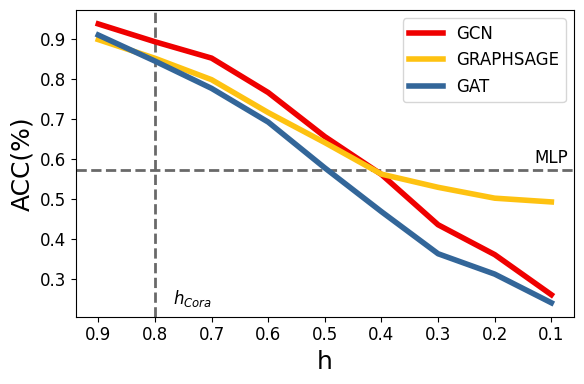

In [12]:
plt.figure(figsize=(6, 4))
plt.axhline(y=mlp_acc, color='#696969', linestyle='--', linewidth=2)
plt.text(x=0.07, y=mlp_acc+0.03, s='MLP', ha='right', va='center', fontsize=12, color='black')
cora_homo = 0.799187
plt.axvline(x=cora_homo, color='#696969', linestyle='--', linewidth=2)
plt.text(y=0.25, x=cora_homo-0.1, s=r'$h_{Cora}$', ha='right', va='center', fontsize=12, color='black')
for model in res:
    plt.plot(homos[::-1], res[model][::-1], label=model.upper(), markersize=fontsize['markersize'], c=colors[list(res.keys()).index(model)], linewidth=linewidth)  
plt.ylabel('ACC(%)', fontsize=fontsize['label'])
plt.xlabel('h', fontsize=fontsize['label'])
plt.xticks(fontsize=fontsize['ticks'])
plt.yticks(fontsize=fontsize['ticks'])
plt.rcParams.update({'font.size':fontsize['legend']})
plt.legend()
plt.gca().invert_xaxis()
# plt.title('GNN Performance on SBM-Reconstructed Cora Dataset')
plt.tight_layout()
plt.savefig('./motivation.pdf', bbox_inches='tight')